# Эксперимент с обучением FCRN на малом датасете, random crop

### Датасет

Датасет состоит из 56500 изображений (18800 картинок из исходной коллекции, с каждой из них взято по три случайных кропа). Аугментация не проводилась.

RGB изображения процессились с помощью `keras.applications.resnet50.preprocess_input`. После данного препроцессинга, значения пикселей изображения лежат в пределах примерно от -123 до 150. Глубины подавались в модель в исходном виде в метрах.

### Модель

Архитектура модели взята из статьи: https://arxiv.org/pdf/1606.00373.pdf. Основу модели составляет сверточный энкодинг из ResNet50, предобученной на ImageNet. После этого добавляются 5 Up-projection блоков, описанных в статье. Перед каждым блоком добавляется слой BatchNormalization, после каждого блока - дропаут с коэффициентом 0.5.

Модель обучается в 4 этапа, по несколько эпох на каждый: сначала обучаются только разверточные слои, затем разверточные и три последних ResNet-блока, затем разверточные и 6 последних ResNet-блоков, затем все слои.

Параметры обучения сохранены в файле `params.txt`.

## Создание модели

In [1]:
import tensorflow as tf
import keras
import numpy as np
import os

Using TensorFlow backend.


In [2]:
assert tf.test.is_gpu_available()

In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image

In [4]:
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam

In [5]:
def apply_upprojection(nn):
    n_filters = int(nn.shape[-1])
    batchnorm = BatchNormalization()(nn)
    upsampling = UpSampling2D()(batchnorm)
    conv = Conv2D(n_filters // 2, kernel_size=5, padding='same')(upsampling)
    relu = Activation('relu')(conv)
    conv_3 = Conv2D(n_filters // 2, kernel_size=3, padding='same')(relu)
    conv_proj = Conv2D(n_filters // 2, kernel_size=5, padding='same')(upsampling)
    add = Add()([conv_3, conv_proj])
    relu_2 = Activation('relu')(add)
    dropout = Dropout(0.5)(relu_2)
    return dropout


def create_model():
    model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    for layer in model.layers:
        layer.trainable = False
    model.compile(loss='mean_squared_error', optimizer='adam')
    resnet_output = model.output
    nn = Conv2D(1024, kernel_size=1, padding='same')(resnet_output)
    for k in range(5):
        nn = apply_upprojection(nn)
    depth_output = Conv2D(1, kernel_size=3, padding='same')(nn)
    #depth_output = Reshape((224, 224))(depth_output)
    fcrn_model = Model(inputs=model.input, outputs=depth_output)
    return fcrn_model

In [6]:
fcrn_model = create_model()
fcrn_model.summary()

/home/kmouraviev/anaconda/envs/tensorflow/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 10s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________

In [7]:
fcrn_model.save('./model_pretrained.hdf5')

## Загрузка датасета

In [5]:
import h5py
import os

In [6]:
os.environ['HDF5_USE_FILE_LOCKING'] = "FALSE"

In [7]:
!echo $HDF5_USE_FILE_LOCKING

FALSE


In [8]:
try:
    data_file.close()
except:
    pass
data_file = h5py.File('/home/kmouraviev/NYU_dataset_hdf5/data.hdf5', 'r')
rgbs = data_file['data']
depths = data_file['label']

In [75]:
rgbs_train = rgbs[:40000]
rgbs_val = rgbs[40000:]
depths_train = depths[:40000]
depths_val = depths[40000:]

In [43]:
rgbs_train = np.array(rgbs_train)
rgbs_val = np.array(rgbs_val)
depths_train = np.array(depths_train)
depths_val = np.array(depths_val)

In [44]:
datagen = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(rgbs_train)

In [39]:
rgbs_train = np.array([x for x in rgbs_train])
depths_train = np.array([x[np.newaxis, :, :] for x in depths_train])

In [40]:
train_flow = datagen.flow(rgbs_train, depths_train, batch_size=32)
validation_flow = datagen.flow(rgbs_val, depths_val, batch_size=32)

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (224, 224, 3), y.shape = (40000, 1, 1, 224, 224)

In [25]:
fcrn_model.compile(optimizer=Adam(lr=1e-4, decay=1e-4), loss='mean_squared_error')

In [26]:
fcrn_model.fit_generator(train_flow,
                         steps_per_epoch=10,
                         epochs=1,
                         validation_data=[rgbs_val, depths_val])

Epoch 1/1


StopIteration: module 'scipy' has no attribute 'ndimage'

## Обучение

In [62]:
def train_model(fcrn_model, params):
    # initialize params
    batch_sizes = params['batch_size']
    lrs = params['lr']
    decays = params['decay']
    n_epochs = params['n_epoch']
    dir_to_save_weights = params['weights_dir']
    fcrn_model = load_model('./model_pretrained.hdf5')
    if not os.path.exists(dir_to_save_weights):
        os.mkdir(dir_to_save_weights)
    
    # Train network. First stage: only FCN layers
    fcrn_model.compile(optimizer=Adam(lr=lrs[0], decay=decays[0]),
                       loss='mean_squared_error'
                      )
    train_flow = datagen.flow(rgbs_train, depths_train, batch_size=batch_sizes[0])
    fcrn_model.fit(rgbs_train,
                   depths_train, 
                   batch_size=batch_sizes[0], 
                   epochs=n_epochs[0], 
                   validation_data=[rgbs_val, depths_val])
    fcrn_model.save(os.path.join(dir_to_save_weights, 'only_fcn_trained.hdf5'))
    
    # Train network. Second stage: FCN layers and three last ResNet blocks
    after_add12 = False
    for layer in fcrn_model.layers:
        layer.trainable = after_add12
        if layer.name == 'add_12':
            after_add12 = True
    fcrn_model.compile(optimizer=Adam(lr=lrs[1], decay=decays[1]),
                       loss='mean_squared_error'
                      )
    train_flow = datagen.flow(rgbs_train, depths_train, batch_size=batch_sizes[1])
    fcrn_model.fit(rgbs_train,
                   depths_train, 
                   batch_size=batch_sizes[1], 
                   epochs=n_epochs[1], 
                   validation_data=[rgbs_val, depths_val])
    fcrn_model.save(os.path.join(dir_to_save_weights, 'trained_since_add12.hdf5'))
    
    # Train network. Third stage: FCN layers and six last ResNet blocks
    after_add9 = False
    for layer in fcrn_model.layers:
        layer.trainable = after_add9
        if layer.name == 'add_9':
            after_add9 = True
    fcrn_model.compile(optimizer=Adam(lr=lrs[2], decay=decays[2]),
                       loss='mean_squared_error'
                      )
    train_flow = datagen.flow(rgbs_train, depths_train, batch_size=batch_sizes[2])
    fcrn_model.compile(optimizer=Adam(lr=lrs[2], decay=decays[2]),
                       loss='mean_squared_error'
                      )
    fcrn_model.fit(rgbs_train,
                   depths_train, 
                   batch_size=batch_sizes[2], 
                   epochs=n_epochs[2], 
                   validation_data=[rgbs_val, depths_val])
    fcrn_model.save(os.path.join(dir_to_save_weights, 'trained_since_add9.hdf5'))
    
    # Train network. Last stage: all layers are trainable
    for layer in fcrn_model.layers:
        layer.trainable = True
    train_flow = datagen.flow(rgbs_train, depths_train, batch_size=batch_sizes[3])
    fcrn_model.compile(optimizer=Adam(lr=lrs[3], decay=decays[3]),
                       loss='mean_squared_error'
                      )
    fcrn_model.fit(rgbs_train,
                   depths_train, 
                   batch_size=batch_sizes[3], 
                   epochs=n_epochs[3], 
                   validation_data=[rgbs_val, depths_val])
    fcrn_model.save(os.path.join(dir_to_save_weights, 'all_layers_trained.hdf5'))
    
    # Save parameters into directory with model weights
    with open(os.path.join(dir_to_save_weights, 'params.txt'), 'w') as f:
        f.write(str(params))

### Standard training configuration

In [76]:
params = {
    'batch_size': (64, 32, 32, 32),
    'lr': (5e-5, 3e-5, 1e-5, 1e-5),
    'decay': (1e-4, 1e-4, 1e-4, 1e-4),
    'n_epoch': (3, 5, 3, 1),
    'weights_dir': './experiment1_weights'
}

In [77]:
train_model(fcrn_model, params)

Train on 40000 samples, validate on 16541 samples
Epoch 1/3
40000/40000 [==============================] - 510s 13ms/step - loss: 2.0274 - val_loss: 1.0713
Epoch 2/3
40000/40000 [==============================] - 508s 13ms/step - loss: 1.1507 - val_loss: 0.9316
Epoch 3/3
40000/40000 [==============================] - 508s 13ms/step - loss: 0.8771 - val_loss: 0.7842
Train on 40000 samples, validate on 16541 samples
Epoch 1/5
40000/40000 [==============================] - 666s 17ms/step - loss: 0.7586 - val_loss: 0.6129
Epoch 2/5
40000/40000 [==============================] - 662s 17ms/step - loss: 0.5741 - val_loss: 0.6202
Epoch 3/5
40000/40000 [==============================] - 659s 16ms/step - loss: 0.4671 - val_loss: 0.5352
Epoch 4/5
40000/40000 [==============================] - 660s 16ms/step - loss: 0.4024 - val_loss: 0.5235
Epoch 5/5
40000/40000 [==============================] - 662s 17ms/step - loss: 0.3572 - val_loss: 0.4894
Train on 40000 samples, validate on 16541 samples
Ep

## Визуализация работы сети

In [9]:
fcrn_model = load_model('all_layers_trained.hdf5')

In [10]:
rgbs_val = np.array(rgbs[40000::1000])
depths_val = np.array(depths[40000::1000])

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
%%time
depths_predicted = fcrn_model.predict(rgbs_val)

CPU times: user 110 ms, sys: 120 ms, total: 230 ms
Wall time: 209 ms


In [16]:
print("MSE:", np.mean((depths_val - depths_predicted) ** 2))

MSE: 0.3183781041173137


In [22]:
def unpreprocess_rgb(image):
    # make image pixel values between 0 and 1
    image = (image - image.min()) / (image.max() - image.min())
    return image

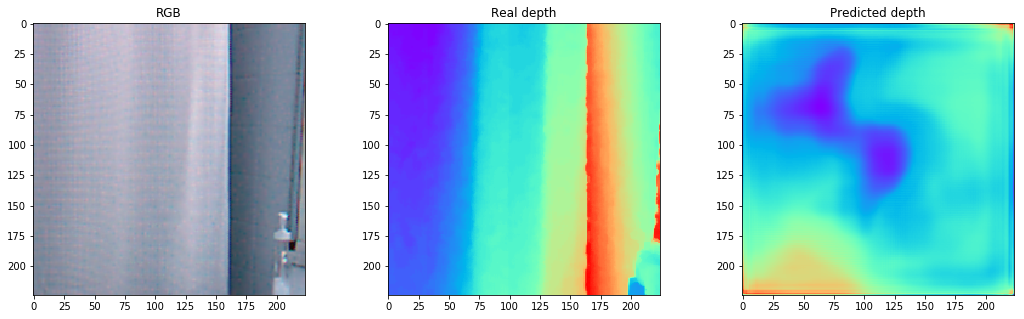

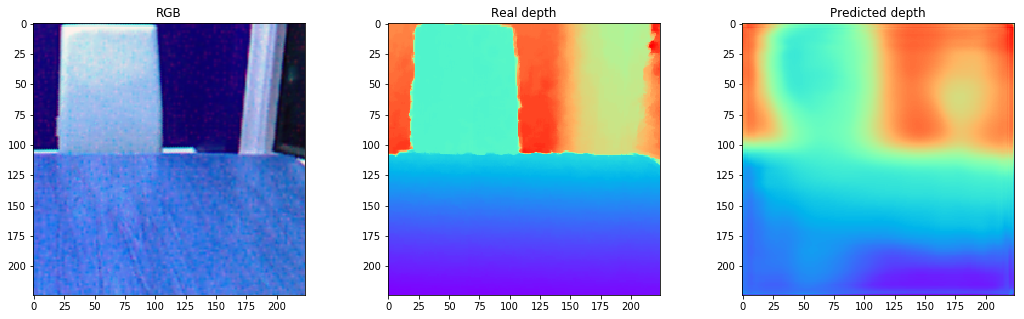

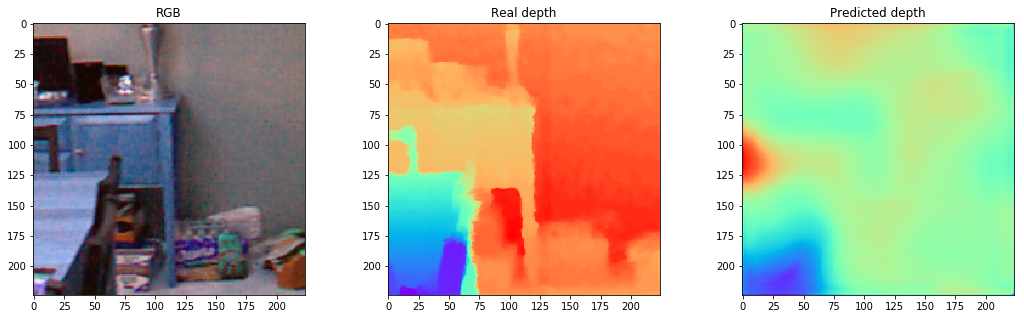

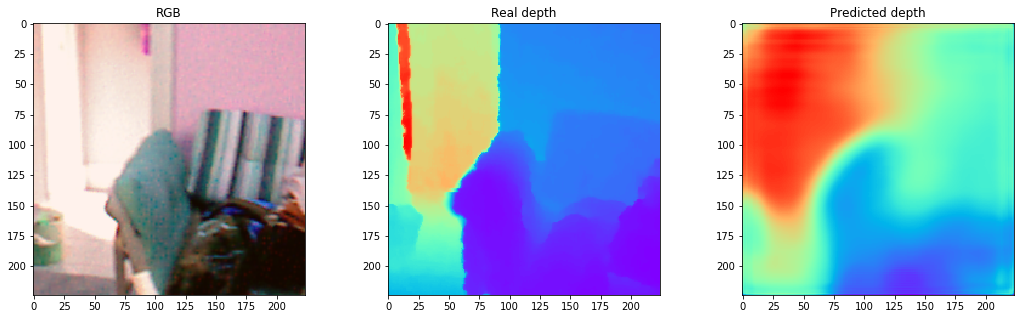

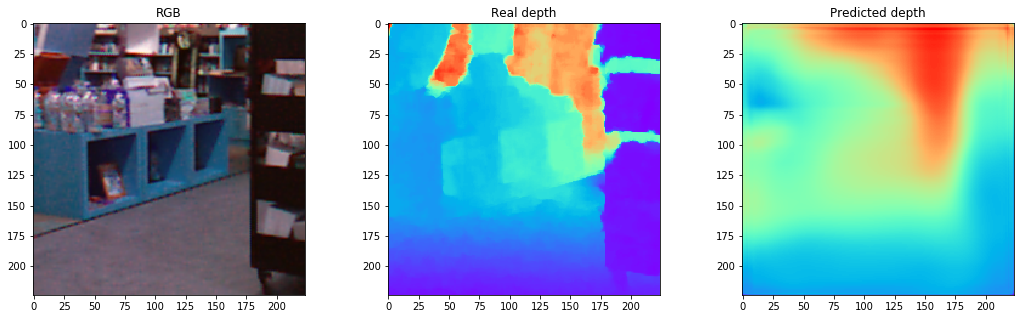

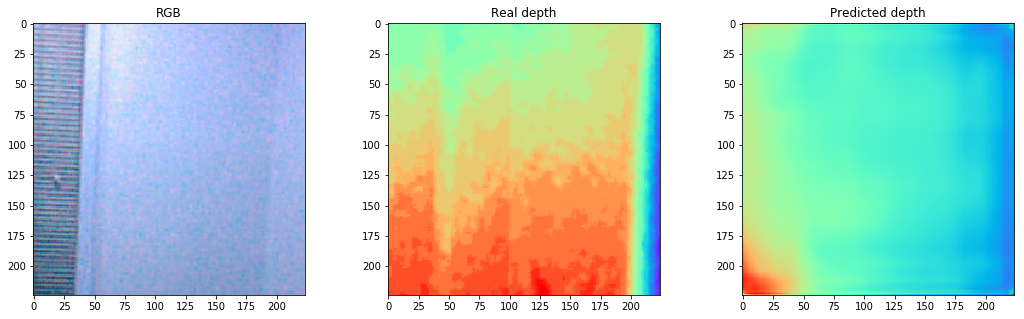

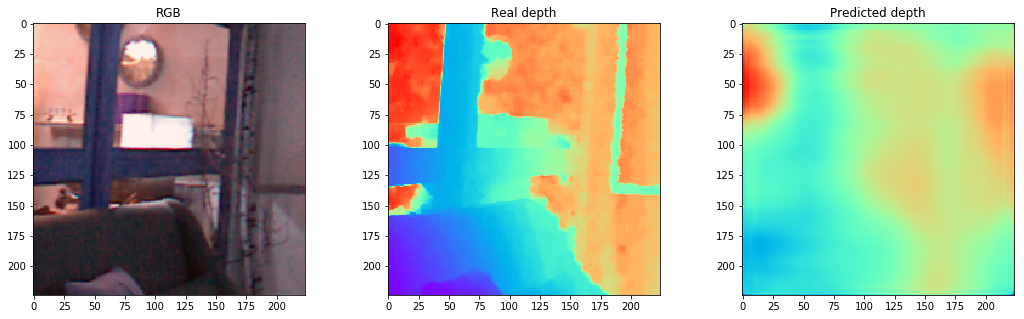

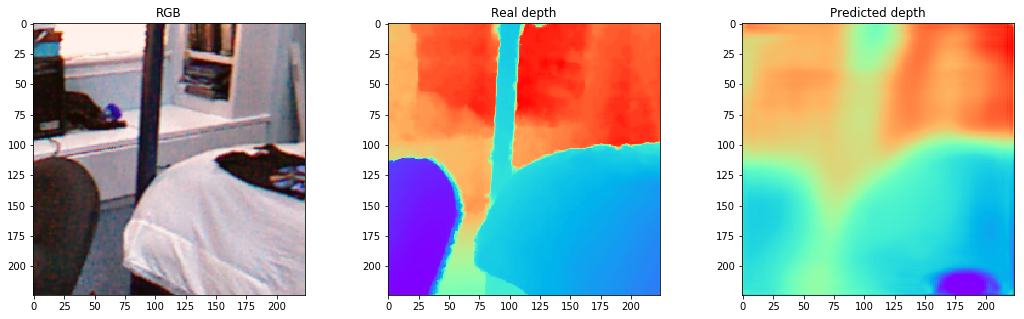

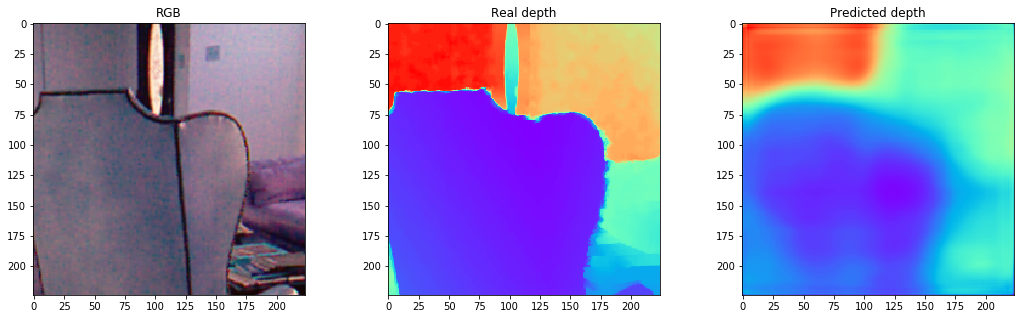

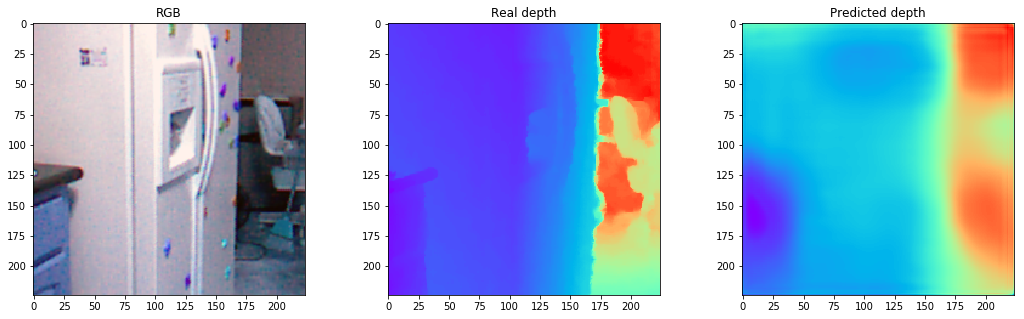

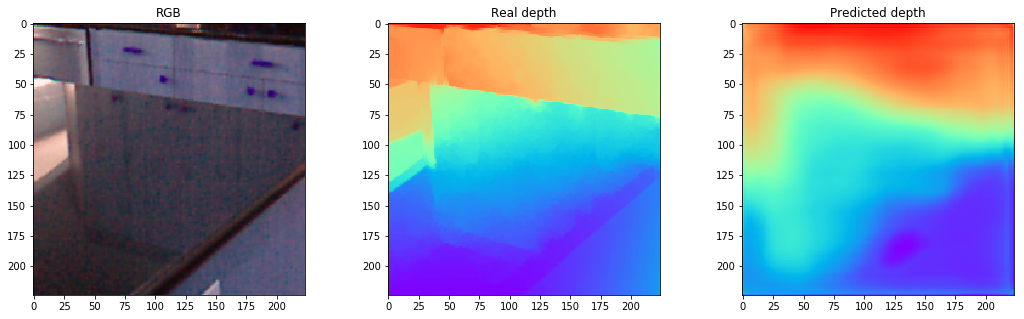

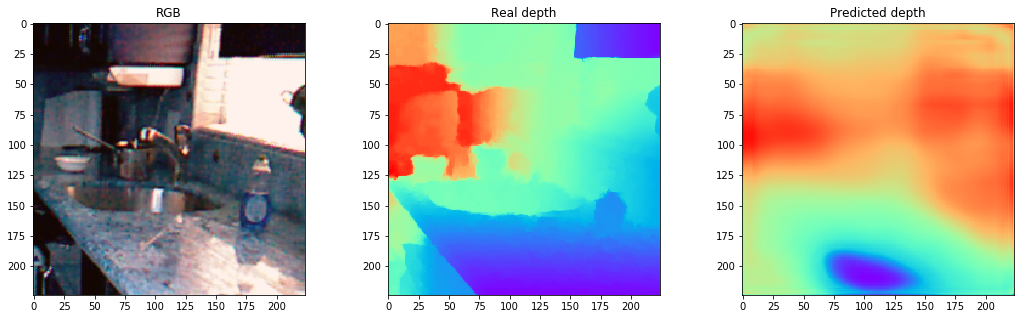

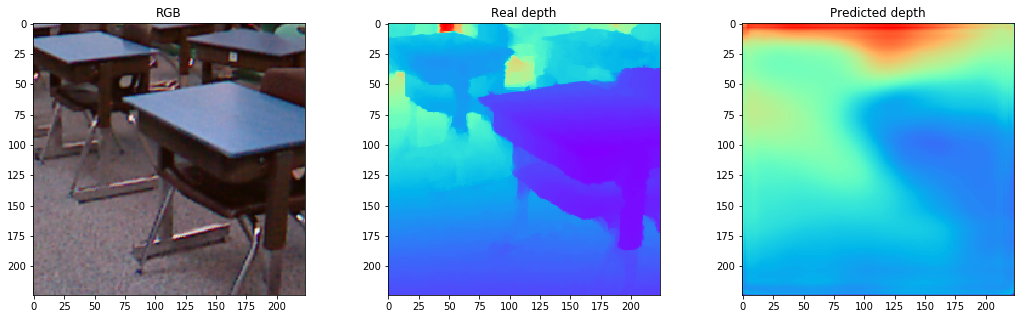

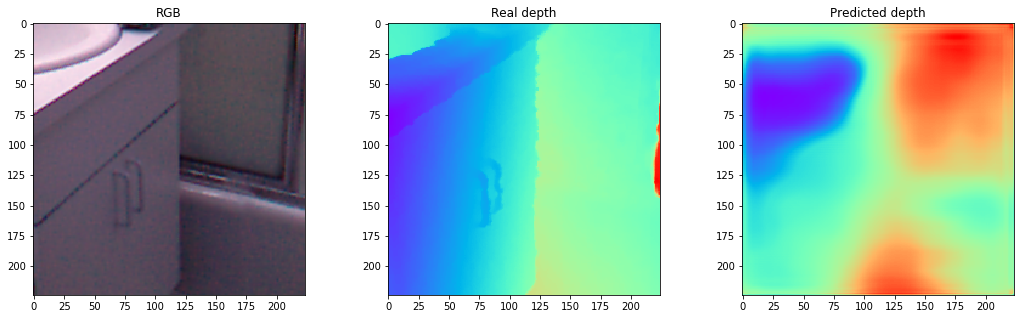

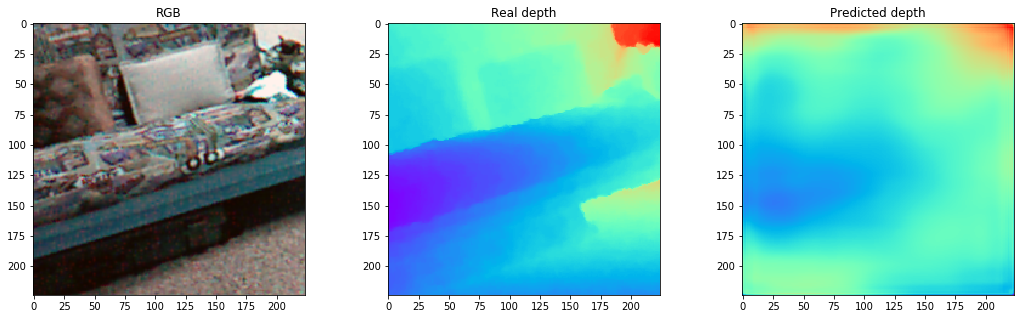

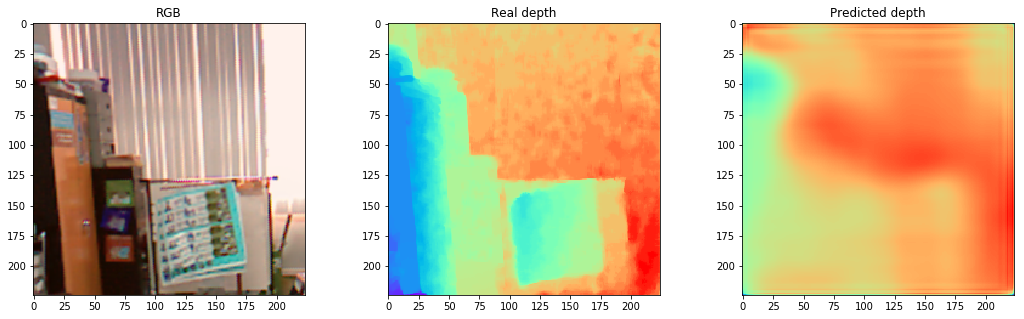

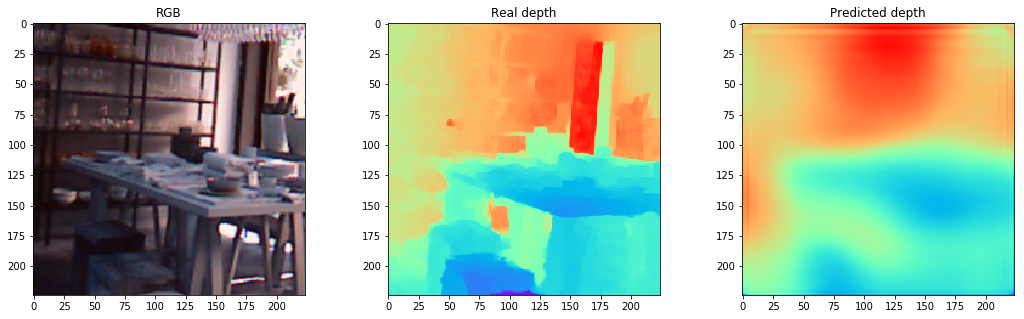

In [23]:
for i in range(len(depths_val)):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("RGB")
    plt.imshow(unpreprocess_rgb(rgbs_val[i]))
    plt.subplot(1, 3, 2)
    plt.title("Real depth")
    plt.imshow(depths_val[i] / 10., cmap='rainbow')
    plt.subplot(1, 3, 3)
    plt.title("Predicted depth")
    plt.imshow(depths_predicted[i] / 10., cmap='rainbow')